works with kernel Python \[conda env:pangu] as constructed in README

run fengwu with 1 GPU and 20 GB memory (must be v100, not gp100 because gp100 only has 16 GB VRAM, but v100 has 32GB)

Make these the default casper modules `module save`

```
Currently Loaded Modules:
  1) ncarenv/24.12  (S)   3) ncarcompilers/1.0.0   5) ucx/1.17.0      7) hdf5/1.12.3    9) cudnn/9.2.0.82-12
  2) intel/2024.2.1       4) cuda/12.3.2           6) openmpi/5.0.6   8) netcdf/4.9.2  10) conda/latest
```

Inferences in conda env:ainwp is different by 0.0001 K from pangu env (after 240 hours)
conda env:ainwp is supposed to replicate realtime runs, but still 0.1 K different from realtime runs

In [1]:
import os
from pathlib import Path

import pandas as pd
import plot_ensemble
import xarray as xr
from earth2studio.data import GFS, DataSource
from earth2studio.data.mpas import MPAS as MPASDataSource
from earth2studio.data.mpas import MPASHybrid
from earth2studio.data.mpas_ens import MPAS as MPASEns
from earth2studio.io import IOBackend, NetCDF4Backend, WPSBackend
from earth2studio.models.px import GraphCastOperational, GraphCastSmall, Pangu6
from earth2studio.run import deterministic
from s3_run_pangu_ecmwf import run_inference, setup_model_sessions

SCRATCH = Path(os.getenv("SCRATCH"))
ai_models_dir = SCRATCH / "ai-models"
date = pd.to_datetime("2018042400", format="%Y%m%d%H")
# date = pd.to_datetime("2024042400", format="%Y%m%d%H")
ic = "mpas"
fhr_end = 120

In [2]:
if True:
    idir = Path(
        "/glade/derecho/scratch/stoedtli/pandac/stoedtli_3dhybrid-60-60-iter_O30kmI60km_benchmark_1/CyclingFC"
    )
    mpas_datasrc = MPASHybrid(
        grid_path=idir / f"{date:%Y%m%d%H}/invariant.655362.nc",
        data_path=f"{idir}/%Y%m%d%H/mpasin.%Y-%m-%d_%H.%M.%S.nc",
        pressure_levels=[50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000],
    )

if False:
    idir = Path("/glade/campaign/mmm/parc/schwartz")
    mpas_datasrc = MPASEns(
        grid_path=idir / "MPAS/15-3km_mesh/grid_mesh/x5.6488066.grid_CONUS.nc",
        data_dir=idir / f"HWT{date.year}/mpas",
    )
if False:
    mpas_datasrc = MPASEns(
        grid_path=idir / "MPAS/15km_mesh/grid_mesh/x1.2621442.grid.nc",
        data_dir=idir / f"HWT{date.year}/mpas_15km",
    )

if False:
    idir = (
        Path(
            "/glade/derecho/scratch/stoedtli/pandac/stoedtli_3dhybrid-60-60-iter_O30kmI60km_benchmark_1/CyclingFC"
        )
        / f"{date:%Y%m%d%H}"
    )
    mpas_datasrc = MPASDataSource(
        grid_path=idir / "invariant.655362.nc",
        data_path=[
            idir / f"diag.{date:%Y-%m-%d_%H.%M.%S}.nc",
            idir / f"p_sfc.{date:%Y-%m-%d_%H.%M.%S}.nc",
        ],
    )

2025-10-24 15:39:16,846 - INFO - Loading cached regridding indices from /glade/u/home/ahijevyc/.cache/earth2studio/mpas_hybrid/invariant.655362_0.25x0.25.npz


In [3]:
model_class = GraphCastOperational
model = model_class.load_model(model_class.load_default_package())

INFO:2025-10-24 15:39:57,422:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-10-24 15:39:57,422 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-10-24 15:39:57,588:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-10-24 15:39:57,588 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
ds = mpas_datasrc(
    pd.date_range(start="20180423T18", end="20180424", freq="6h"),
    ["tp06", "msl", "t2m", "z1000", "t1000", "t925", "w1000", "z", "z925"],
)
ds

<xarray.DataArray (time: 2, variable: 9, lat: 721, lon: 1440)> Size: 150MB
array([[[[ 5.49520382e-06,  5.49520382e-06,  5.49520382e-06, ...,
           5.49520382e-06,  5.49520382e-06,  5.49520382e-06],
         [ 1.02857439e-05,  1.02857439e-05,  1.02857439e-05, ...,
           1.02857439e-05,  1.02857439e-05,  1.02857439e-05],
         [ 1.27007906e-05,  1.27007906e-05,  1.27007906e-05, ...,
           1.27007906e-05,  1.27007906e-05,  1.27007906e-05],
         ...,
         [ 4.53363691e-06,  4.53363691e-06,  4.53363691e-06, ...,
           4.53363691e-06,  4.53363691e-06,  4.53363691e-06],
         [ 3.24194616e-06,  3.24194616e-06,  3.24194616e-06, ...,
           3.24194616e-06,  3.24194616e-06,  3.24194616e-06],
         [ 3.43392776e-06,  3.43392776e-06,  3.43392776e-06, ...,
           3.43392776e-06,  3.43392776e-06,  3.43392776e-06]],

        [[ 1.01410547e+05,  1.01410547e+05,  1.01410547e+05, ...,
           1.01410547e+05,  1.01410547e+05,  1.01410547e+05],
         [ 1.00998555e+05,  1.00998555e+05,  1.00998555e+05, ...,
           1.00998555e+05,  1.00998555e+05,  1.00998555e+05],
         [ 1.00845211e+05,  1.00845211e+05,  1.00845211e+05, ...,
           1.00845211e+05,  1.00845211e+05,  1.00845211e+05],
...
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 8.92348813e+03,  8.92348813e+03,  8.92348813e+03, ...,
           8.92348813e+03,  8.92348813e+03,  8.92348813e+03],
         [ 8.69950384e+03,  8.69950384e+03,  8.69950384e+03, ...,
           8.69950384e+03,  8.69950384e+03,  8.69950384e+03],
         [ 8.38439770e+03,  8.38439770e+03,  8.38439770e+03, ...,
           8.38439770e+03,  8.38439770e+03,  8.38439770e+03],
         ...,
         [ 6.66422412e+03,  6.66422412e+03,  6.66422412e+03, ...,
           6.66422412e+03,  6.66422412e+03,  6.66422412e+03],
         [ 6.65780566e+03,  6.65780566e+03,  6.65780566e+03, ...,
           6.65780566e+03,  6.65780566e+03,  6.65780566e+03],
         [ 6.65509766e+03,  6.65509766e+03,  6.65509766e+03, ...,
           6.65509766e+03,  6.65509766e+03,  6.65509766e+03]]]],
      shape=(2, 9, 721, 1440))
Coordinates:
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    initial_time  datetime64[ns] 8B 2018-04-14T18:00:00
    nCells        (lat, lon) int64 8MB 8 8 8 8 8 8 8 8 8 8 ... 2 2 2 2 2 2 2 2 2
  * variable      (variable) object 72B 'tp06' 'msl' 't2m' ... 'z' 'z925'
  * time          (time) datetime64[ns] 16B 2018-04-23T18:00:00 2018-04-24

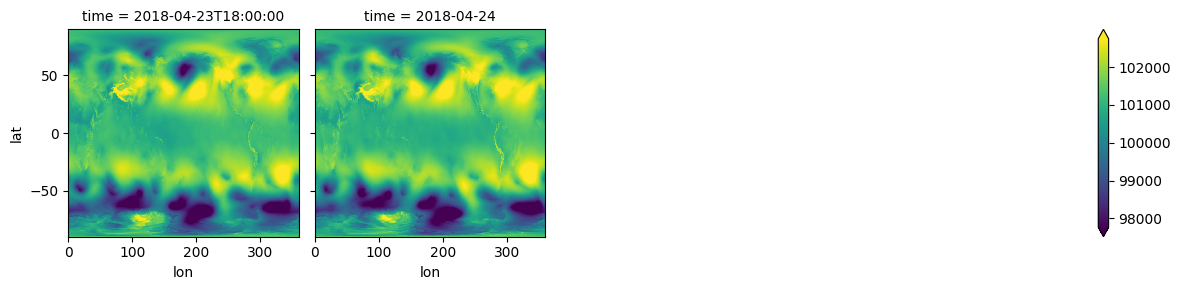

In [5]:
ds.sel(variable="msl").plot(col="time", col_wrap=4, robust=True)

In [9]:
nsteps = 8
ofile = SCRATCH / f"test_GRAP:{date:%Y-%m-%d_%H}.nc"
if os.path.exists(ofile):
    os.remove(ofile)
#io = NetCDF4Backend(ofile, backend_kwargs={"mode": "w"})
io = WPSBackend(SCRATCH, map_source=model.__class__.__name__, static_fields=["lsm", "z"])
deterministic([date], nsteps, model, mpas_datasrc, io)
io.close() 

2025-10-24 16:17:18.121 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-10-24 16:17:18.121 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-10-24 16:17:18.891 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from MPASHybrid
2025-10-24 16:17:19.427 | INFO     | earth2studio.run:deterministic:136 - Inference starting!



Running inference: 100%|██████████| 9/9 [00:39<00:00,  4.36s/it]

2025-10-24 16:17:58.686 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete


In [7]:
from metpy.constants import Re
Re

<Quantity(6371008.77, 'meter')>

In [36]:
ort_session_24, ort_session_6 = setup_model_sessions(ai_models_dir)

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:129 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] CUDA failure 100: no CUDA-capable device is detected ; GPU=-1 ; hostname=crhtc91 ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=282 ; expr=cudaSetDevice(info_.device_id); 

 when using [('CUDAExecutionProvider', {'a

In [42]:
da

<xarray.DataArray (channel: 69, lat: 721, lon: 1440)> Size: 287MB
array([[[ 8.1969879e+02,  8.1969879e+02,  8.1969879e+02, ...,
          8.1969879e+02,  8.1969879e+02,  8.1969879e+02],
        [ 8.2532727e+02,  8.2532727e+02,  8.2532727e+02, ...,
          8.2532727e+02,  8.2532727e+02,  8.2532727e+02],
        [ 8.3430536e+02,  8.3430536e+02,  8.3430536e+02, ...,
          8.3430536e+02,  8.3430536e+02,  8.3430536e+02],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 6.6550977e+03,  6.6550977e+03,  6.6550977e+03, ...,
          6.6550977e+03,  6.6550977e+03,  6.6550977e+03],
        [ 6.6578057e+03,  6.6578057e+03,  6.6578057e+03, ...,
          6.6578057e+03,  6.6578057e+03,  6.6578057e+03],
        [ 6.6642241e+03,  6.6642241e+03,  6.6642241e+03, ...,
          6.6642241e+03,  6.6642241e+03,  6.6642241e+03],
...
         -1.2707704e+00, -1.2707704e+00, -1.2707704e+00],
        [ 3.7036851e-01,  3.7036851e-01,  3.7036851e-01, ...,
          3.7036851e-01,  3.7036851e-01,  3.7036851e-01],
        [ 2.5460875e+00,  2.5460875e+00,  2.5460875e+00, ...,
          2.5460875e+00,  2.5460875e+00,  2.5460875e+00]],

       [[ 2.5806137e+02,  2.5806137e+02,  2.5806137e+02, ...,
          2.5806137e+02,  2.5806137e+02,  2.5806137e+02],
        [ 2.5763022e+02,  2.5763022e+02,  2.5763022e+02, ...,
          2.5763022e+02,  2.5763022e+02,  2.5763022e+02],
        [ 2.5731320e+02,  2.5731320e+02,  2.5731320e+02, ...,
          2.5731320e+02,  2.5731320e+02,  2.5731320e+02],
        ...,
        [ 2.1409164e+02,  2.1409164e+02,  2.1409164e+02, ...,
          2.1409164e+02,  2.1409164e+02,  2.1409164e+02],
        [ 2.1084758e+02,  2.1084758e+02,  2.1084758e+02, ...,
          2.1084758e+02,  2.1084758e+02,  2.1084758e+02],
        [ 2.0855087e+02,  2.0855087e+02,  2.0855087e+02, ...,
          2.0855087e+02,  2.0855087e+02,  2.0855087e+02]]],
      shape=(69, 721, 1440), dtype=float32)
Coordinates:
    initial_time  datetime64[ns] 8B 2018-04-14T18:00:00
    time          datetime64[ns] 8B 2018-04-24
  * lat           (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon           (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * channel       (channel) object 552B 'z1000' 'z925' 'z850' ... 'v10m' 't2m'
Attributes:
    time:         2018-04-24 00:00:00
    source_file:  /glade/derecho/scratch/stoedtli/pandac/stoedtli_3dhybrid-60...

In [41]:
output_dir = Path(f"/glade/derecho/scratch/ahijevyc/ai-models/output/panguweather/{date:%Y%m%d%H}")

da = ds.rename(variable="channel")
inferences = run_inference(da, ort_session_24, ort_session_6, fhr_end)
for fcst in inferences:
    fhr = fcst.prediction_timedelta.squeeze() / pd.to_timedelta("1h")
    output_filename = os.path.join(output_dir, f"pangu_{ic}_hybrid_pred_{fhr:03.0f}.nc")
    print(output_filename)
    # zlib compression can reduce by 1/3 but takes long time (versus almost instantaneous)
    fcst.to_netcdf(output_filename)

Processing 2018-04-24T00:00:00.000000000 - 6 hour


ValueError: dimension 'init_time' already exists as a scalar variable

In [40]:
output_dir = Path(f"/glade/derecho/scratch/ahijevyc/ai-models/output/panguweather/{date:%Y%m%d%H}")

for member in ds.member.data:
    da = ds.sel(member=member).rename(variable="channel").rename(Time="time")
    all_exist = True
    for fhr in range(6, fhr_end+1, 6):
        output_filename = os.path.join(output_dir, f"pangu_{ic}{member}_pred_{fhr:03.0f}.nc")
        if not os.path.exists(output_filename):
            print(output_filename, 'no exists')
            all_exist = False
            break
    if all_exist:
        print(f"all {date} {ic}{member} exist")
        continue
    inferences = run_inference(da, ort_session_24, ort_session_6, fhr_end)
    for fcst in inferences:
        fhr = fcst.prediction_timedelta.squeeze() / pd.to_timedelta("1h")
        output_filename = os.path.join(output_dir, f"pangu_{ic}{member}_pred_{fhr:03.0f}.nc")
        print(output_filename)
        # zlib compression can reduce by 1/3 but takes long time (versus almost instantaneous)
        fcst.to_netcdf(output_filename)

AttributeError: 'DataArray' object has no attribute 'member'

In [ ]:
ifiles = []
for member in ds.member.data:
    ifiles.append(sorted(list(output_dir.glob(f"pangu_{ic}{member}_pred_???.nc"))))
da = (
    xr.open_mfdataset(
        ifiles,
        combine="nested",
        concat_dim=["member", "prediction_timedelta"],
    )
    .rename(lat="latitude", lon="longitude")
    .assign_coords(member=ds.member)
    .sel(channel="z500")
    .rename(__xarray_dataarray_variable__="z", prediction_timedelta="step")
    .squeeze(dim="init_time")
)
da

In [ ]:
import argparse
args = argparse.Namespace
args.ic = ic.upper()
args.model = "panguweather"
fig = plot_ensemble.plot_forecast_grid(args, da.sortby("member"), plotdays=range(1, fhr_end//24+1))

In [ ]:
member = 4
inferences = xr.open_mfdataset(output_dir.glob(f"pangu_{ic}{member}_pred_???.nc"))
inferences = inferences.sel(lat=slice(60,20), lon=slice(220, 300))
inferences.sel(channel="z500").squeeze().__xarray_dataarray_variable__.plot(col="prediction_timedelta", col_wrap=6)

In [ ]:
inferences